# Glacier Peak Scouting Report - 20107

In [1]:
import pandas as pd
import sqlalchemy as sa
import sys

# Add IRScout to project path. Note: unless your  name is not Stacy, you
#   probably need to modify this file path
project_path = ('C:\Users\stacy\OneDrive\Projects\scouting17'
                '\irsScouting2017\Server')
sys.path.append(project_path)

# Setup Jupyter for displaying plots
%matplotlib notebook

In [2]:
# Get a database connection
connection_string = ('postgresql://irs1318:irs1318'
                     '@localhost:5432/scouting')
engine = sa.create_engine(connection_string)
conn = engine.connect()

In [3]:
import scouting.output as out
import scouting.event as evt
evt.EventDal.set_current_event('wasno')
evt.EventDal.get_current_event()

u'wasno'

In [4]:
out.get_report()

C:/Users/stacy/Desktop/Report_wasno2017Mar25_175235.xlsx


In [5]:
sql_measures = sa.text(
    "SELECT events.name AS event, matches.name AS match, levels.name AS level, dates.name AS date, "
    "teams.name AS team, alliances.name AS alliance, "
    "stations.name AS station, phases.name AS phase, actors.name AS actor, tasks.name AS task, "
    "measures.capability AS capability, measures.successes as successes, measures.attempts AS attempts, "
    "measures.cycle_times as cycle_times, measuretypes.name AS measuretype, reasons.name AS reason, "
    "attempts.name AS attempt "
    "FROM ((((((((((((measures FULL OUTER JOIN teams ON measures.team_id=teams.id) "
    "LEFT JOIN events ON measures.event_id=events.id) "
    "LEFT JOIN matches ON measures.match_id=matches.id) "
    "LEFT JOIN levels ON measures.level_id=levels.id) "
    "LEFT JOIN dates ON measures.date_id=dates.id) "
    "LEFT JOIN alliances ON measures.alliance_id=alliances.id) "
    "LEFT JOIN stations ON measures.station_id=stations.id) "
    "LEFT JOIN phases ON measures.phase_id=phases.id) "
    "LEFT JOIN actors ON measures.actor_id=actors.id) "
    "LEFT JOIN tasks ON measures.task_id=tasks.id) "
    "LEFT JOIN reasons ON measures.reason_id=reasons.id) "
    "LEFT JOIN measuretypes ON measures.measuretype_id=measuretypes.id) "
    "LEFT JOIN attempts ON measures.attempt_id=attempts.id "
    "WHERE events.name='wasno' AND actors.name='robot';")
measures = pd.read_sql(sql_measures, conn)
measures.query("team == '1318'").query("task == 'pushTouchPad'").query("phase == 'finish'")

,event,match,level,date,team,alliance,station,phase,actor,task,capability,successes,attempts,cycle_times,measuretype,reason,attempt
558,wasno,002-q,qual,2017-03-25T11:07:00,1318,blue,3,finish,robot,pushTouchPad,0,1,1,0,boolean,na,summary
1114,wasno,012-q,qual,2017-03-25T12:17:00,1318,blue,3,finish,robot,pushTouchPad,0,1,1,0,boolean,na,summary
1364,wasno,017-q,qual,2017-03-25T12:52:00,1318,blue,3,finish,robot,pushTouchPad,0,1,1,0,boolean,na,summary
1713,wasno,023-q,qual,2017-03-25T14:34:00,1318,red,3,finish,robot,pushTouchPad,0,1,1,0,boolean,na,summary
2098,wasno,030-q,qual,2017-03-25T15:23:00,1318,red,2,finish,robot,pushTouchPad,0,1,1,0,boolean,na,summary


# Create the Dataframe

In [6]:
# Get Sums for non-alliance data
evt = 'waamv'
sel_sums = sa.text(
    "SELECT teams.name AS team, phases.name AS phase, tasks.name AS task, "
    "actors.name AS actor, "
    "SUM(successes) AS sum_successes, SUM(attempts) AS sum_attempts "
    "FROM ((((teams FULL OUTER JOIN measures ON teams.id=measures.team_id) "
    "LEFT JOIN tasks ON tasks.id = measures.task_id) "
    "LEFT JOIN phases ON phases.id = measures.phase_id) "
    "LEFT JOIN events ON events.id = measures.event_id) "
    "LEFT JOIN actors ON actors.id = measures.actor_id "
    "WHERE events.name = '" + evt + "' AND actors.name<>'alliance' "
    "GROUP BY teams.name, tasks.name, phases.name, actors.name "
    "ORDER BY teams.name, phases.name, tasks.name, actors.name;")
df_sums = pd.read_sql(sel_sums, conn)
    
df_sums = df_sums.set_index(['team', 'phase', 'actor', 'task'])
df_sums = df_sums.stack()
df_sums = df_sums.unstack([1, 2, 3, 4])
df_sums = df_sums.sort_index(axis = 1, level = [0, 1, 2])

for col in df_sums:
    if col[3] == 'sum_successes':
        phase = col[0]
        actor = col[1]
        task = col[2]
        percent = df_sums[(phase, actor, task, 'sum_successes')] /\
                  df_sums[(phase, actor, task, 'sum_attempts')]
        df_sums.insert(0, (phase, actor, task, 'percent'), percent)
        
df_sums = df_sums.sort_index(axis = 1, level = [0,1,2])
df_sums.head(5)

phase          auto                                                     \
actor         pilot                                 robot                
task       dropGear                      holdFuelCapacity                
      sum_successes sum_attempts percent    sum_successes sum_attempts   
team                                                                     
1258            NaN          NaN     NaN             11.0         10.0   
1294            NaN          NaN     NaN              3.0          0.0   
1318            NaN          NaN     NaN              8.0          1.0   
1899            NaN          NaN     NaN              0.0          0.0   
1983            NaN          NaN     NaN              0.0          0.0   

phase                                                                 ...    \
actor                                                                 ...     
task                 holdGear                          moveBaseline   ...     
        percent sum_successes sum_attempts    percent sum_successes   ...     
team                                                                  ...     
1258   1.100000           8.0          1.0   8.000000           6.0   ...     
1294        inf          10.0          1.0  10.000000           7.0   ...     
1318   8.000000          10.0          1.0  10.000000           6.0   ...     
1899        NaN           7.0          0.0        inf           2.0   ...     
1983        NaN          12.0          0.0        inf           7.0   ...     

phase              teleop                                       \
actor               robot                                        
task  pickupGearRetrieval     placeGear                          
                  percent sum_successes sum_attempts   percent   
team                                                             
1258                  1.0          14.0         16.0  0.875000   
1294                  1.0          21.0         21.0  1.000000   
1318                  1.0          15.0         22.0  0.681818   
1899                  1.0          14.0         19.0  0.736842   
1983                  1.0          19.0         22.0  0.863636   

phase                                                                     \
actor                                                                      
task  shootHighBoiler                        shootLowBoiler                
        sum_successes sum_attempts   percent  sum_successes sum_attempts   
team                                                                       
1258             20.0         20.0  1.000000            3.0          3.0   
1294              2.0          6.0  0.333333            NaN          NaN   
1318              2.0         10.0  0.200000            NaN          NaN   
1899              0.0          0.0       NaN            NaN          NaN   
1983              0.0          0.0       NaN            NaN          NaN   

phase          
actor          
task           
      percent  
team           
1258      1.0  
1294      NaN  
1318      NaN  
1899      NaN  
1983      NaN  

[5 rows x 105 columns]

# Plot Some Data

<IPython.core.display.Javascript object>


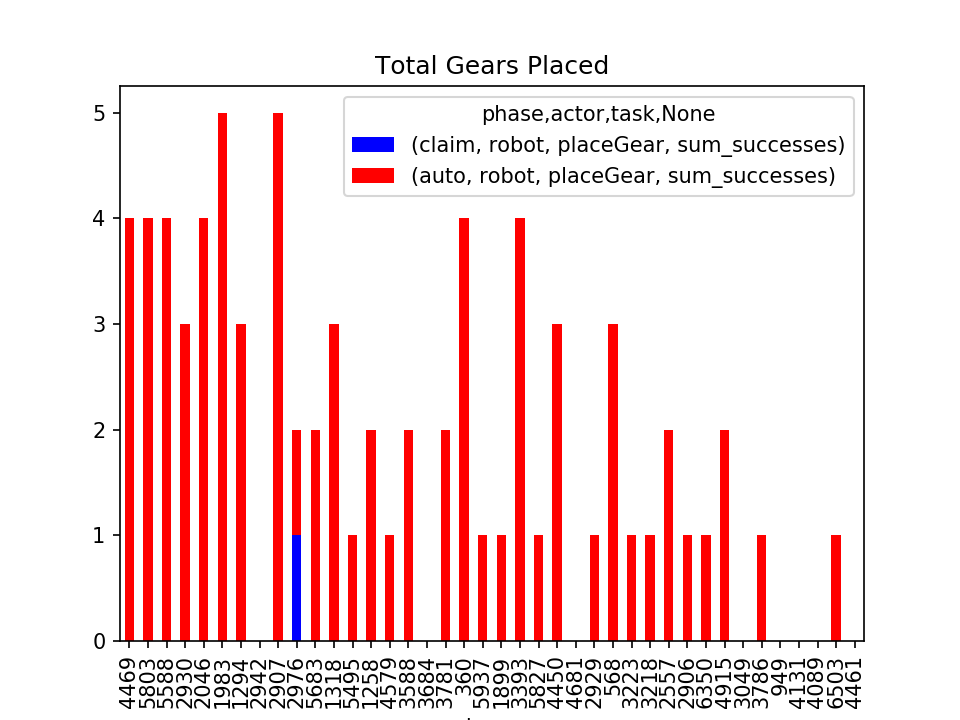

In [7]:
placeGears = df_sums.xs('placeGear', axis = 1, level = 2, drop_level = False)
placeGears = placeGears.xs('sum_successes', axis = 1, level = 3, drop_level = False)
placeGears['total'] = placeGears.sum(axis = 1)
placeGears = placeGears.sort_values('total', axis = 0, ascending = False)
del placeGears['total']
placeGears[[1,0]].plot.bar(stacked = True, sort_columns = 1, title = 'Total Gears Placed', colormap = 'bwr')

In [8]:
lastmatch = sa.text(
"SELECT matches.name AS match FROM matches RIGHT JOIN measures on matches.id=measures.match_id "
    "ORDER BY matches.name DESC;"
)
df_lastmatch = pd.read_sql(lastmatch, conn)
df_lastmatch.iloc[0]

match    na
Name: 0, dtype: object

In [9]:
sched = sa.text(
"SELECT * FROM schedules "
"WHERE event = 'wasno';"
)

df_sched = pd.read_sql(sched, conn)
df_sched

,id,date,event,level,match,alliance,team,station
0,3854,2017-03-25T12:31:00,wasno,qual,014-q,red,2903,3
1,3855,2017-03-25T12:31:00,wasno,qual,014-q,blue,4683,1
2,3856,2017-03-25T12:31:00,wasno,qual,014-q,blue,2412,2
3,3857,2017-03-25T12:31:00,wasno,qual,014-q,blue,5588,3
4,3858,2017-03-25T12:38:00,wasno,qual,015-q,red,4911,1
5,3859,2017-03-25T12:38:00,wasno,qual,015-q,red,1294,2
6,3860,2017-03-25T12:38:00,wasno,qual,015-q,red,4469,3
7,3861,2017-03-25T12:38:00,wasno,qual,015-q,blue,5748,1
8,3862,2017-03-25T12:38:00,wasno,qual,015-q,blue,6503,2
9,3863,2017-03-25T12:38:00,wasno,qual,015-q,blue,949,3


In [10]:
sql = sa.text(
"with current as (select s.match, date from schedules sched, status s "
"where sched.event = s.event and sched.match = s.match limit 1 ) "
"select * from ( "
"    select row_number() over (partition by team order by sched.date desc) as r, "
"    sched.* "
"    from schedules sched, current c "
"    where sched.date <= c.date "
") row_schedule "
"    where "
"    row_schedule.r <= 3 "
"    order by team, date desc;")
lb_df = pd.read_sql(sql, conn)
lb_df

,r,id,date,event,level,match,alliance,team,station
0,1,3971,2017-03-25T15:44:00,wasno,qual,033-q,blue,1294,3
1,2,3928,2017-03-25T14:55:00,wasno,qual,026-q,blue,1294,2
2,3,3859,2017-03-25T12:38:00,wasno,qual,015-q,red,1294,2
3,1,3949,2017-03-25T15:23:00,wasno,qual,030-q,red,1318,2
4,2,3908,2017-03-25T14:34:00,wasno,qual,023-q,red,1318,3
5,3,3875,2017-03-25T12:52:00,wasno,qual,017-q,blue,1318,3
6,1,3985,2017-03-25T16:05:00,wasno,qual,036-q,red,1778,2
7,2,3946,2017-03-25T15:16:00,wasno,qual,029-q,blue,1778,2
8,3,3915,2017-03-25T14:41:00,wasno,qual,024-q,blue,1778,1
9,1,3954,2017-03-25T15:30:00,wasno,qual,031-q,red,1899,1


In [11]:
num_matches = 12
mtchs = sa.text(
    "with current AS (SELECT s.match, date from schedules sched, "
    "status s WHERE sched.event = s.event "
    "AND sched.match = s.match limit 1 ), "

    "recent_matches as ( SELECT * FROM ( "
    "SELECT row_number() over (partition by team order by sched.date desc) as r, "
    " sched.* from schedules sched, current c WHERE sched.date <= c.date )"
    " row_schedule WHERE row_schedule.r <= " + str(num_matches) + " ORDER by team, date desc), "

    "team_match_count as ( "
        "select team, count(team) as team_matches from recent_matches group by team"
              ") "
    "SELECT * FROM team_match_count;")
df = pd.read_sql(mtchs, conn)
df

,team,team_matches
0,1294,5
1,3070,6
2,2412,6
3,2903,5
4,4681,6
5,5588,6
6,2557,6
7,6503,6
8,2928,6
9,2605,5


In [12]:
num_matches = 12
mtchs = sa.text(
    "with current AS (SELECT s.match, date from schedules sched, "
    "status s WHERE sched.event = s.event "
    "AND sched.match = s.match limit 1 ), "

    "recent_matches as ( SELECT * FROM ( "
    "SELECT row_number() over (partition by team order by sched.date desc) as r, "
    " sched.* from schedules sched, current c WHERE sched.date <= c.date )"
    " row_schedule WHERE row_schedule.r <= " + str(num_matches) + " ORDER by team, date desc), "

    "team_match_count as ( "
        "select team, count(team) as team_matches from recent_matches group by team"
              ") "
    "SELECT * FROM recent_matches;")
df = pd.read_sql(mtchs, conn)
df

,r,id,date,event,level,match,alliance,team,station
0,1,3971,2017-03-25T15:44:00,wasno,qual,033-q,blue,1294,3
1,2,3928,2017-03-25T14:55:00,wasno,qual,026-q,blue,1294,2
2,3,3859,2017-03-25T12:38:00,wasno,qual,015-q,red,1294,2
3,4,3842,2017-03-25T12:17:00,wasno,qual,012-q,red,1294,3
4,5,3815,2017-03-25T11:42:00,wasno,qual,007-q,blue,1294,3
5,1,3949,2017-03-25T15:23:00,wasno,qual,030-q,red,1318,2
6,2,3908,2017-03-25T14:34:00,wasno,qual,023-q,red,1318,3
7,3,3875,2017-03-25T12:52:00,wasno,qual,017-q,blue,1318,3
8,4,3845,2017-03-25T12:17:00,wasno,qual,012-q,blue,1318,3
9,5,3785,2017-03-25T11:07:00,wasno,qual,002-q,blue,1318,3


In [13]:
# Check Query
num_matches = 12
evt = 'wasno'
select_sum = sa.text(
"with current AS (SELECT s.match, date from schedules sched, "
"status s WHERE sched.event = s.event "
"AND sched.match = s.match limit 1 ), "

"recent_matches as ( SELECT * FROM ( "
"SELECT row_number() over (partition by team order by sched.date desc) as r, "
" sched.* from schedules sched, current c WHERE sched.date <= c.date )"
" row_schedule WHERE row_schedule.r <= " + str(num_matches) + " ORDER by team, date desc), "

"team_match_count as ( "
    "select team, count(team) as team_matches from recent_matches group by team"
          ") "

"SELECT teams.name AS team, phases.name AS phase, tasks.name AS task, actors.name AS actor, "
"MAX(team_match_count.team_matches) AS matches, "
"SUM(successes) AS sum_successes, SUM(attempts) AS sum_attempts, AVG(cycle_times) "
"FROM ((((teams FULL OUTER JOIN measures ON teams.id=measures.team_id) "
"LEFT JOIN tasks ON tasks.id = measures.task_id) "
"LEFT JOIN phases ON phases.id = measures.phase_id) "
"LEFT JOIN events ON events.id = measures.event_id) "
"LEFT JOIN actors ON actors.id = measures.actor_id "
"LEFT JOIN matches ON matches.id = measures.match_id "
"LEFT JOIN team_match_count ON team_match_count.team = teams.name "
"RIGHT JOIN recent_matches ON recent_matches.match = matches.name AND team_match_count.team = teams.name "
    "AND recent_matches.team = team_match_count.team "
"WHERE events.name = '" + evt + "' AND actors.name<> 'alliance' "
"GROUP BY teams.name, tasks.name, phases.name, actors.name "
"ORDER BY teams.name, phases.name, tasks.name, actors.name;")
df = pd.read_sql(select_sum, conn)
df

,team,phase,task,actor,matches,sum_successes,sum_attempts,avg
0,1294,auto,dropGear,pilot,5,0,0,0.0
1,1294,auto,holdFuelCapacity,robot,5,2,2,0.0
2,1294,auto,holdGear,robot,5,4,4,0.0
3,1294,auto,moveBaseline,robot,5,4,7,0.0
4,1294,auto,placeGear,robot,5,3,4,0.0
5,1294,auto,startingLocation,robot,5,0,0,0.0
6,1294,finish,climbRope,robot,5,35,35,0.0
7,1294,finish,maintainContact,robot,5,4,4,0.0
8,1294,finish,pushTouchPad,robot,5,5,5,0.0
9,1294,teleop,pickupFuelFloor,robot,5,0,0,0.0
